# Ритейл — Анализ программы лояльности

### Задача**:**

Проанализировать программу лояльности магазина.

### Цель**:**
Оценить результаты внедрения программы лояльности, понять насколько сработала программа лояльности, стоит ли ее использовать дальше.

### Задачи проекта: 
- провести исследовательский анализ данных показать общую картину;
- получить основные ритейл-метрики по когортам у клиентов внутри программы лояльности и вне ее;
- проанализировать насколько сработала текущая программа лояльности;
- проверить гипотезы;

#### Шаг 1. Подготовка данных
   - Замените названия столбцов
   - Проверьте пропуски и типы данных
   - Добавить отдельный столбец дат
   - Проверить и удалить дубликаты
   - Проверить аномальные значения
   - Добавить столбец суммы чека

#### Шаг 2. Исследовательский анализ данных
- Сколько всего событий в логе
- Сколько всего пользователей в логе
- Сколько всего товаров в логе
- Какие самые популярные товары
- Какое количество магазинов
- Динамаика продаж по магазинам
- Сколько в среднем покупок приходится на пользователя?
- За какой период представлены данные? Найти максимальную и минимальную дату. Построить гистограмму по дате и времени
- определить критерии разбиения на когорты

#### Шаг 3. Решение основных вопросов заказчика
- расчет основных метрик: середний чек, среднее количество покупок на пользователя, LTV
- расчет основных метрик в разрезе магазинов
- расчет основных метрик в разрезе когорт

#### Шаг 4. Проверка статистических гипотез
- определение и проверка двух нулевых гипотез:
1. Н0 - Средние чеки клиентов участвующих и неучаствующих в программе лояльности равны
2. Н0 - Среднее количество покупок на клиентов участвующих и неучаствующих в программе лояльности равны

#### Шаг 5. Выводы для заказчика
- выводы
- рекомендации

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy import stats as st

#### Шаг 1. Подготовка данных

In [2]:
df = pd.read_csv('retail_dataset.csv')
prod_df = pd.read_csv('product_codes.csv')

In [3]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


In [4]:
prod_df = prod_df.rename(columns={'productID':'item_id'})

In [5]:
print('количество уникальных продуктов:',prod_df.item_id.nunique())
print('Общее количество записей по ценам продуктов:',prod_df.item_id.count())

количество уникальных продуктов: 3159
Общее количество записей по ценам продуктов: 9969


In [6]:
prod_df.duplicated().sum()

0

In [7]:
prod_df[prod_df.price_per_one == 0].count()

item_id          382
price_per_one    382
dtype: int64

In [8]:
zero_price_items = prod_df[prod_df.price_per_one == 0].item_id.unique()
prod_df[prod_df.item_id.isin(zero_price_items)].sort_values(by='item_id').groupby('item_id')\
                                     .agg({'price_per_one':['count','min', 'max', 'mean']}).price_per_one\
                                     .reset_index().sort_values(by='count', ascending=False)

,item_id,count,min,max,mean
381,POST,15,0.0,40.00,16.638000
272,79321,11,0.0,12.46,7.013636
284,84406B,10,0.0,8.29,4.253000
109,22112,9,0.0,12.72,7.543333
79,21673,9,0.0,3.36,1.812222
...,...,...,...,...,...
95,21841,1,0.0,0.00,0.000000
91,21805,1,0.0,0.00,0.000000
295,84546,1,0.0,0.00,0.000000
231,35644,1,0.0,0.00,0.000000


In [10]:
prod_df_piv = prod_df.groupby('item_id')\
                     .agg({'price_per_one':['count','min', 'max', 'mean']}).price_per_one\
                     .reset_index().sort_values(by='count', ascending=False)

prod_df_piv.head(10)
prod_df_piv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3159 entries, 3150 to 3158
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  3159 non-null   object 
 1   count    3159 non-null   int64  
 2   min      3159 non-null   float64
 3   max      3159 non-null   float64
 4   mean     3159 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 148.1+ KB


Количество уникальных продуктов: 3159<br>
Общее количество записей по ценам продуктов: 9969<br>
Для 382 позиций указана нулевая цена<br>
Для 2419 продуктов из файла есть записи с разными ценами. Может быть несколько причин этому: цены менялись в течении времени (время установления цен нам не дано), ошибка в выгрузке, разные цены в разных магазинах. Для корректного объединения таблиц и дальнейшей работы с ними нам нужно иметь только одно значение цены для каждго продукта. Пока уточнить причину разных цен невозможно для целей проекта будем использовать среднюю цену для каждого продукта. 

In [11]:
prod_df_piv = prod_df_piv.loc[:,['item_id', 'mean']].rename(columns={'mean':'price_per_one'})
prod_df_piv.head(3)

,item_id,price_per_one
3150,DOT,278.734425
3151,M,253.765932
3153,S,30.125172


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


In [13]:
df.head(3)

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0


In [14]:
df = df.rename(columns={'item_ID':'item_id', 
                        'Quantity':'quantity', 
                        'purchasedate':'purchase_date',
                        'CustomerID':'customer_id',
                        'ShopID':'shop_id',
                        'purchaseid':'purchase_id'})

In [15]:
# приведем поле "purchase_date" к формату datetime
df.purchase_date = pd.to_datetime(df.purchase_date, format='%Y-%m-%d %H:%M:%S')

In [16]:
# добавим столбец с датой и приведем его к типу datetime64
df['date'] = pd.to_datetime(df.loc[:,('purchase_date')]).dt.normalize()

In [17]:
# приведем значение loyalty_program к типу integer
df.loyalty_program = df.loyalty_program.astype('int')

посмотрим количество дубликатов и удалим их

In [18]:
df.duplicated().sum()
# df[df.duplicated()==True].sort_values(by='purchase_id').head(10)

1033

In [19]:
# удалим дубликаты
df = df.drop_duplicates()

In [20]:
# посмотрим не попали ли пользователи без id в "программу лояльности"
df[df.customer_id.isnull()].groupby('loyalty_program',as_index=False).agg({'purchase_id':'count'})

,loyalty_program,purchase_id
0,0,36148


все пропуски в customer_id это клиенты не участвующие в программе лояльности. Видимой ошибки тут нет.

In [21]:
df.describe()

,quantity,customer_id,loyalty_program
count,104302.000000,68154.000000,104302.000000
mean,7.883003,21011.165889,0.224464
std,329.565540,1766.665163,0.417231
min,-74216.000000,18025.000000,0.000000
25%,0.000000,19533.000000,0.000000
50%,2.000000,20977.000000,0.000000
75%,7.000000,22633.000000,0.000000
max,74214.000000,23962.000000,1.000000


в датасете есть запись с отрицательным количеством заказов. Изучим их и экстремальные значения

In [22]:
print('количество записей отрицательных заказов:',df[df.quantity <0]['purchase_id'].count())
print('количество записей нормальных заказов:',df[df.quantity >0]['purchase_id'].count())
print('сумма отрицательных заказов', df[df.quantity <0]['quantity'].sum())
print('сумма нормальных заказов:', df[df.quantity >0]['quantity'].sum())
print('количество нулевых заказов:', df[df.quantity == 0]['purchase_id'].count())

количество записей отрицательных заказов: 2076
количество записей нормальных заказов: 69864
сумма отрицательных заказов -119554
сумма нормальных заказов: 941767
количество нулевых заказов: 32362


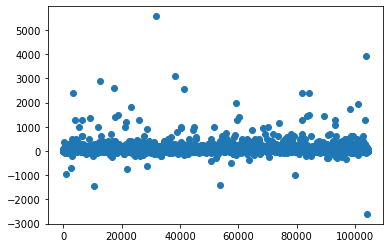

In [23]:
# посмотрим распределение количества товара в заказе отбросив экстремальные значения, чтоб видеть разброс
df1 = df[df.quantity > -8000]
df1 = df1[df1.quantity < 74214]

x_values = pd.Series(range(0,len(df1)))
plt.scatter(x_values, df1['quantity']);

# sns.set(rc={'figure.figsize':(15,5)})
# sns.boxplot(data=df1, x='Quantity');

In [24]:
# посмотирим 95 и 99 пересентили датасета
np.percentile(df.quantity, [95,99])

array([24., 99.])

In [25]:
# посмотирим 1 и 2 пересентили датасета
np.percentile(df.quantity, [1,2])

array([-3.,  0.])

In [26]:
# посмотрим на обе записи с экстремальными значениями поля quantity нашего датасета
df[df.quantity.isin([-74216,74214])]

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
49411,C541433,23166,-74216,2017-01-18 10:17:00,18025.0,Shop 0,0,2017-01-18
69074,541431,23166,74214,2017-01-18 10:01:00,18025.0,Shop 0,0,2017-01-18


обе записи сформированы в один день с разницей в несколько минут для одного пользователя. Последовательность их указывает скорей всего на ошибочное проведение продажи и ее последующую отмену

In [27]:
# посомтрим на уникальных пользователей, для которых были произведены продажи с отрицательным количеством
neg_orders = df[df.quantity < 0]['customer_id'].unique()
neg_orders

array([20239., 23190., 19825., 22686., 20380., 18827.,    nan, 22714.,
       20779., 19359., 19978., 18150., 20285., 18089., 21337., 18162.,
       21502., 20949., 23381., 20359., 19884., 20684., 23520., 21995.,
       22774., 19983., 19477., 19351., 22380., 18151., 18532., 21193.,
       21280., 19302., 18760., 20631., 21931., 19854., 22883., 18096.,
       18326., 20388., 22225., 19541., 23529., 23924., 21392., 23047.,
       22000., 18265., 20590., 23855., 23356., 22985., 18772., 18180.,
       21387., 23090., 21249., 19372., 20367., 19278., 22764., 20529.,
       20306., 20325., 23121., 19999., 19255., 22867., 19087., 19637.,
       22178., 20322., 20900., 23720., 18391., 21475., 18113., 21052.,
       22540., 20475., 21824., 23797., 20105., 23754., 20184., 23107.,
       18238., 21870., 18729., 22396., 21214., 21543., 20894., 22986.,
       23748., 22994., 18768., 20122., 18454., 22286., 22909., 23068.,
       19835., 22607., 22409., 20970., 18794., 21560., 18092., 20990.,
      

In [28]:
# проверим еще на одном пользователе наше предположение об отмене продажи
df[df.customer_id == 20239][df.item_id == '22776']

<ipython-input-28-19b71eeb0554>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.customer_id == 20239][df.item_id == '22776']


,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date
64,C539944,22776,-2,2016-12-23 11:38:00,20239.0,Shop 0,0,2016-12-23
50953,539326,22776,11,2016-12-17 09:22:00,20239.0,Shop 0,0,2016-12-17
89023,542351,22776,11,2017-01-27 12:13:00,20239.0,Shop 0,0,2017-01-27


В датасете есть отрицательные значения количества. По всей видимости это или возврат или корректировка неверно внесенного заказа. На это указывает и префикс в purchase_id таких заказов<br>
Уберем отрицательные (2076 записи) и нулевые (32362 записей) заказы из датасета. В рамках проета мы оцениваем эфективность внедрения программы лояльности через совершенные покупки разными когортами, записи с нулевыми покупками в данном контексте равнозначны отсутсвтию этих записей<br>
Так же уберем после этого заказы, где количество единиц продукции больше 99 персентиля, чтоб исключить влияние выбросов

In [29]:
df1 = df[df.quantity > 0]
np.percentile(df1.quantity, [95,99])

array([ 39., 119.])

Для 99% пользователей количество товара в одной транзакции не более 119 единиц

In [30]:
df1 = df1[df1.quantity <=np.percentile(df1.quantity, 99)]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69186 entries, 0 to 105334
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      69186 non-null  object        
 1   item_id          69186 non-null  object        
 2   quantity         69186 non-null  int64         
 3   purchase_date    69186 non-null  datetime64[ns]
 4   customer_id      53232 non-null  float64       
 5   shop_id          69186 non-null  object        
 6   loyalty_program  69186 non-null  int64         
 7   date             69186 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 4.8+ MB


In [31]:
# проверим для всех ли продуктов из датасета есть цена за единицу в получившемся файле с ценами
items_price = prod_df_piv.item_id.unique()
items_df = df1.item_id.unique()
no_price = []
have_price = []
for i in items_df:
    if i in items_price:
        have_price.append(i)
    else:
        no_price.append(i)
print(len(no_price))
# print(len(items_price), len(items_df))

0


In [32]:
# добавим в датасет цену за единицу продукта из таблицы 'prod_df_piv'
df1 = df1.merge(prod_df_piv, on='item_id')
df1.head(3)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69186 entries, 0 to 69185
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      69186 non-null  object        
 1   item_id          69186 non-null  object        
 2   quantity         69186 non-null  int64         
 3   purchase_date    69186 non-null  datetime64[ns]
 4   customer_id      53232 non-null  float64       
 5   shop_id          69186 non-null  object        
 6   loyalty_program  69186 non-null  int64         
 7   date             69186 non-null  datetime64[ns]
 8   price_per_one    69186 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 5.3+ MB


In [33]:
# добавим в датасет поле с общей суммой чека
df1['total_amt'] = df1.apply(lambda row: row['quantity'] * row['price_per_one'], axis=1)
df1['year_month'] = df1['purchase_date'].dt.to_period('M')

df1.head(3)

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,price_per_one,total_amt,year_month
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,2016-12-10,1.81,19.91,2016-12
1,540418,21873,1,2017-01-07 11:04:00,NaN,Shop 0,0,2017-01-07,1.81,1.81,2017-01
2,541516,21873,2,2017-01-18 17:34:00,NaN,Shop 0,0,2017-01-18,1.81,3.62,2017-01


1. Данные по стоимости продуктов:<br>
- Количество уникальных продуктов: 3159
- Общее количество записей по ценам продуктов: 9969
- Для 382 позиций указана нулевая цена
- Для 2419 продуктов из файла есть записи с разными ценами. Может быть несколько причин этому: цены менялись в течении времени (время установления цен нам не дано), ошибка в выгрузке, разные цены в разных магазинах. Для корректного объединения таблиц и дальнейшей работы с ними нам нужно иметь только одно значение цены для каждго продукта. Для целей проекта использовали среднюю цену для каждого продукта. Данные требуют уточнений.
<br>
<br>
2. Данные по продажам:<br>
- в датасете по продажам есть записи с отрицательным количеством заказов. По всей видимости это или возврат или корректировка неверно внесенного заказа. На это указывает и префикс в purchase_id таких заказов
- для анализа убрали отрицательные (2076 записи) и нулевые (32362 записей) заказы из датасета. В рамках проета мы оцениваем эфективность внедрения программы лояльности через совершенные покупки разными когортами, записи с нулевыми покупками в данном контексте равнозначны отсутсвтию этих записей
- убрали заказы, где количество единиц продукции больше 99 персентиля (у 99% пользователей количество товара в одной транзакции не более 119 единиц), чтоб исключить влияние выбросов

#### Шаг 2. Исследовательский анализ данных

После этапа подготовки данных из первоначального датасета из 105335 записей с у нас осталось 69186 записей<br>
Только для 53232 записей у нас есть id пользователя

In [34]:
print('количество уникальных идентифицированных пользователей:', df1.customer_id.nunique())
print('среднее количество совершенных покупок на уникального пользователя:', round(df1.customer_id.count() 
                                                                                   / df1.customer_id.nunique(),1))
print('количество уникальных продуктов:', df1.item_id.nunique())
print('общее количество магазинов:', df1.shop_id.nunique())

количество уникальных идентифицированных пользователей: 1650
среднее количество совершенных покупок на уникального пользователя: 32.3
количество уникальных продуктов: 2771
общее количество магазинов: 31


In [35]:
# ТОП-10 самых продаваемых товаров (по количеству)
df1.groupby('item_id', as_index=False).agg({'quantity':'sum'}).sort_values(by='quantity', ascending=False).head(10)

,item_id,quantity
382,21212,6449
2500,85123A,5725
2482,85099B,5723
1013,22197,4161
1254,22469,3846
2321,84879,3768
1721,22961,3470
2358,84946,3255
1600,22834,3210
1153,22355,3170


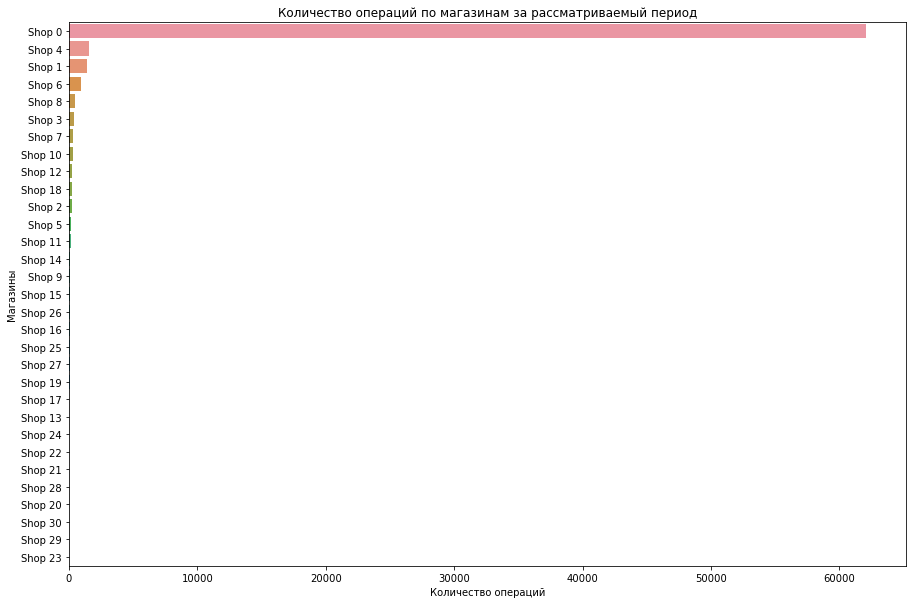

In [36]:
# количество операций по магазинам
gr1 = df1.groupby('shop_id', as_index=False)\
    .agg({'quantity':'count'})\
    .sort_values(by='quantity', ascending=False)

# fig = px.bar(gr1, x='shop_id', y='quantity',text_auto='.2s',
#             title="Количество операций по магазинам за рассматриваемый период")
# fig.show()
plt.figure(figsize=(15, 10))
sns.barplot(data=gr1, x='quantity', y='shop_id')
plt.title("Количество операций по магазинам за рассматриваемый период")
plt.xlabel('Количество операций')
plt.ylabel('Магазины')
plt.show()

С большим отрывом лидером по количеству проведенных транзакций является Shop0

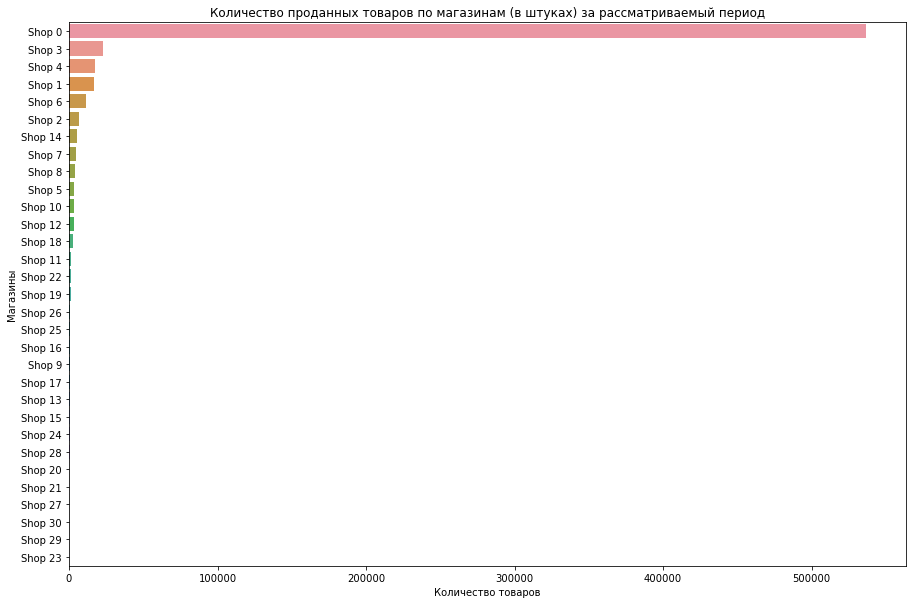

In [37]:
# количество проданных товаров по магазинам (в штуках)
gr1 = df1.groupby('shop_id', as_index=False)\
    .agg({'quantity':'sum'})\
    .sort_values(by='quantity', ascending=False)\

plt.figure(figsize=(15, 10))
sns.barplot(data=gr1, x='quantity', y='shop_id')
plt.title("Количество проданных товаров по магазинам (в штуках) за рассматриваемый период")
plt.xlabel('Количество товаров')
plt.ylabel('Магазины')
plt.show()

С большим отрывом лидером по количеству проданных единиц товаров является Shop0

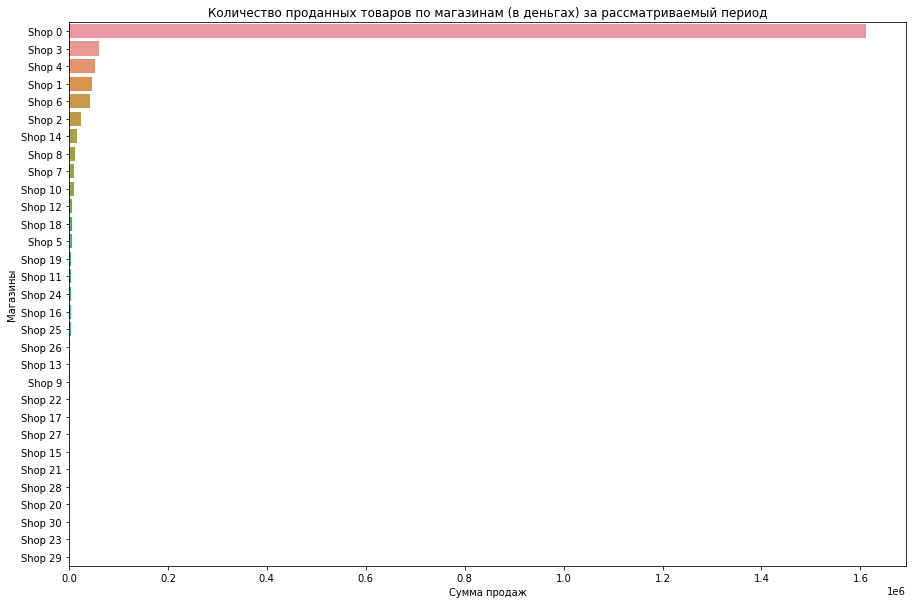

In [38]:
# количество проданных товаров по магазинам (в деньгах)
gr1 = df1.groupby('shop_id', as_index=False)\
    .agg({'total_amt':'sum'})\
    .sort_values(by='total_amt', ascending=False)\

# fig = px.bar(gr1, x='shop_id', y='total_amt',text_auto='.2s',
#             title="Количество проданных товаров по магазинам (в деньгах) за рассматриваемый период")
# fig.show()
plt.figure(figsize=(15, 10))
sns.barplot(data=gr1, x='total_amt', y='shop_id')
plt.title("Количество проданных товаров по магазинам (в деньгах) за рассматриваемый период")
plt.xlabel('Сумма продаж')
plt.ylabel('Магазины')
plt.show()

С большим отрывом лидером по продажам (в деньгаз) является Shop0

In [39]:
df1[df1.shop_id == 'Shop 0'].total_amt.sum()/df1.total_amt.sum()

0.8274727782956615

Абсолютным лидером в продажах является Shop0 (82%)

In [40]:
print(df.date.min())
print(df.date.max())

2016-12-01 00:00:00
2017-02-28 00:00:00


Представленные в датасете данные за период с 01-12-2016 по 28-02-2017

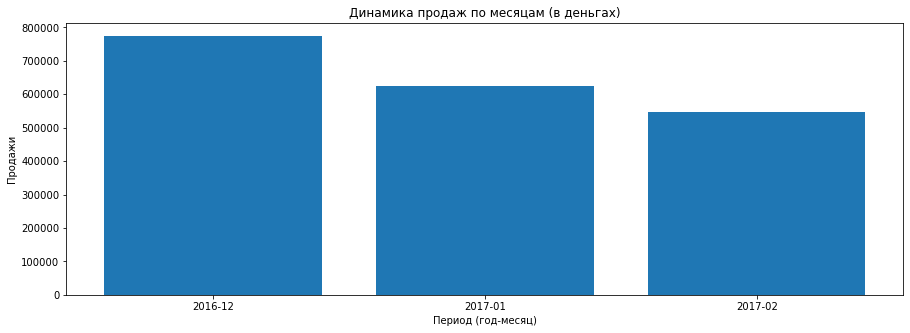

In [41]:
# динамика продаж по месяцам (в деньгах)
gr = df1.groupby('year_month', as_index=False)\
    .agg({'total_amt':'sum'})
gr['year_month'] = gr['year_month'].astype('str')

plt.figure(figsize=(15, 5))
plt.bar(gr['year_month'], gr['total_amt'])
plt.title('Динамика продаж по месяцам (в деньгах)')
plt.xlabel('Период (год-месяц)')
plt.ylabel('Продажи')
plt.show()

наблюдается постепенное снижение продаж от месяца к месяцу на предоставленном отрезке времени <br>
Для многоих сфер такая динамика в эти периоды может быть связана с сезонными колебаниями. Сказать точней можно только на основании данных по ётим месяцам предыдущих лет

- Представленные в датасете данные за период с 01-12-2016 по 28-02-2017
- количество уникальных идентифицированных пользователей: 1650
- среднее количество совершенных покупок на уникального пользователя: 32.3
- количество уникальных приобретенных продуктов: 2771
- общее количество магазинов: 31
- Абсолютным лидером в продажах является Shop_0 (82% всех продаж)
- наблюдается постепенное снижение продаж от месяца к месяцу на предоставленном отрезке времени

#### Шаг 3. Решение основных вопросов заказчика

In [42]:
# середний чек, среднее количество покупок на пользователя
avg1 = df1.groupby(['year_month','loyalty_program'],as_index=False)\
    .agg({'customer_id':'nunique','total_amt':'sum', 'quantity':'sum'})

In [43]:
avg1['avg_amt'] = round(avg1.total_amt / avg1.customer_id, 1)
avg1['avg_qty'] = round(avg1.quantity / avg1.customer_id, 1)
avg1

,year_month,loyalty_program,customer_id,total_amt,quantity,avg_amt,avg_qty
0,2016-12,0,551,560963.664759,182984,1018.1,332.1
1,2016-12,1,315,213316.636275,59066,677.2,187.5
2,2017-01,0,503,494526.183510,173621,983.2,345.2
3,2017-01,1,225,130363.720265,46387,579.4,206.2
4,2017-02,0,488,396511.918329,135159,812.5,277.0
5,2017-02,1,250,151737.278473,53375,606.9,213.5


Ввиду существенной концентрации продаж в одном магазине (Shop0) расчет метрик по магазинам не даст нам каких-то рельтатов для последующих выводов

Для разбиения по когортам возьмем за общее событие совершение первой покупки пользователем в определенном месяце. Признак для разбиения наличие или отсутствие регистрации в программе лояльности

In [44]:
df1.head(3)

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,date,price_per_one,total_amt,year_month
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,2016-12-10,1.81,19.91,2016-12
1,540418,21873,1,2017-01-07 11:04:00,NaN,Shop 0,0,2017-01-07,1.81,1.81,2017-01
2,541516,21873,2,2017-01-18 17:34:00,NaN,Shop 0,0,2017-01-18,1.81,3.62,2017-01


In [45]:
# найдем пользователей которые в начале были не зарегистрированны в программе, а потом сзарегистрировались
qq = df1.groupby(['customer_id']).agg({'loyalty_program':'mean'}).reset_index()
qq = qq[qq.loyalty_program < 1]
qq[qq.loyalty_program > 0]
# таких пользователей нет

,customer_id,loyalty_program


In [46]:
# функция формирует профили клиентов, по которым мы сможем дальше проводить когортный анализ и проверять гипотезы
def get_profiles(df):

    profiles = (
        df.sort_values(by=['customer_id', 'purchase_date'])
        .groupby('customer_id')
        .agg(
            {
                'purchase_date': 'first',
                'quantity': 'sum',
                'purchase_id': 'count',
                'loyalty_program': 'first',
                'total_amt' : 'sum',
                'year_month' : 'first',
            }
        )
        .rename(columns={'purchase_id': 'purchases'})
        .reset_index()
    )

    return profiles

In [47]:
profiles = get_profiles(df1)
profiles['avg_bill'] = profiles.total_amt / profiles.purchases

In [48]:
profiles.head(10)

,customer_id,purchase_date,quantity,purchases,loyalty_program,total_amt,year_month,avg_bill
0,18026.0,2016-12-07 14:57:00,574,60,0,1718.362024,2016-12,28.639367
1,18027.0,2016-12-16 19:09:00,974,16,0,1311.263286,2016-12,81.953955
2,18029.0,2017-02-02 16:01:00,180,16,0,385.261000,2017-02,24.078813
3,18031.0,2017-02-16 12:33:00,83,15,0,370.659667,2017-02,24.710644
4,18035.0,2017-01-18 09:50:00,1180,36,0,3614.032738,2017-01,100.389798
5,18038.0,2017-01-12 12:43:00,513,88,0,1947.140071,2017-01,22.126592
6,18040.0,2017-02-25 13:51:00,81,9,0,260.897000,2017-02,28.988556
7,18041.0,2017-02-17 10:30:00,202,27,0,592.739071,2017-02,21.953299
8,18044.0,2017-02-21 13:51:00,152,20,0,402.710000,2017-02,20.135500
9,18049.0,2016-12-14 12:58:00,877,68,0,2198.817345,2016-12,32.335549


In [49]:
profiles.total_amt.sum()

1753397.9912194402

In [50]:
df1.total_amt.sum()

1947419.4016116003

при разбиении на когорты были проигнорированы и ни куда не вошли записи, в которых отсутсвует customer_id

посмотреть динамику LTV можно только по когортам пользователей первого периода

In [51]:
# пользователи первого периода
ltv_prof = profiles[profiles.year_month == '2016-12'][['customer_id', 'loyalty_program']]\
        .merge(df1[['customer_id', 'total_amt', 'year_month']],on='customer_id', how='left')

ltv_prof.groupby(['year_month', 'loyalty_program'], as_index=False)\
        .agg({'total_amt':'sum'})
ltv_prof.pivot_table(index='loyalty_program', columns='year_month', aggfunc={'total_amt':'sum'})\
        .reset_index().total_amt.rename(columns={'year_month':'loyalty_program'})

year_month,2016-12,2017-01,2017-02
0,461908.794980,239397.115918,184637.997476
1,213316.636275,76030.127008,73622.439065


In [52]:
ltv_prof.groupby(['year_month', 'loyalty_program'],as_index=False).agg({'total_amt':'sum'})

,year_month,loyalty_program,total_amt
0,2016-12,0,461908.794980
1,2016-12,1,213316.636275
2,2017-01,0,239397.115918
3,2017-01,1,76030.127008
4,2017-02,0,184637.997476
5,2017-02,1,73622.439065


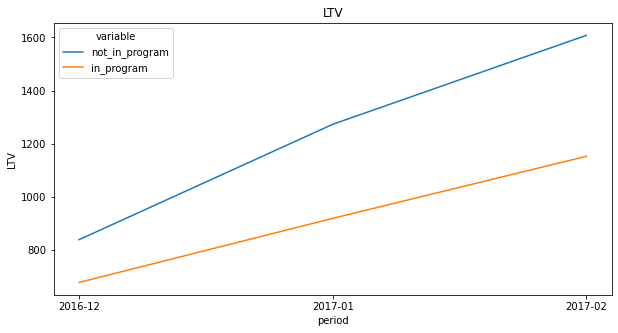

In [53]:
ltv = ltv_prof.pivot_table(index='loyalty_program', columns='year_month', aggfunc={'total_amt':'sum'})\
        .reset_index().total_amt.rename(columns={'year_month':'loyalty_program'}).cumsum(axis=1).T

ltv = ltv.reset_index().rename(columns={0: 'not_in_program', 1:'in_program'})
ltv.not_in_program = ltv.not_in_program / ltv_prof[ltv_prof.loyalty_program == 0].customer_id.nunique()
ltv.in_program = ltv.in_program / ltv_prof[ltv_prof.loyalty_program == 1].customer_id.nunique()

# ltv['year_month'] = pd.to_datetime(ltv['year_month'])
ltv['year_month'] = ltv['year_month'].astype('str')
# ltv['year_month'] = pd.to_datetime(ltv['year_month'], format='%Y-%m')
# ltv['year_month'] = ltv['year_month'].to_timestamp

plt.figure(figsize=(10, 5))
ax = sns.lineplot(x='year_month', y='value', hue='variable', 
             data=pd.melt(ltv, ['year_month']))
plt.title('LTV')
plt.ylabel('LTV')
plt.xlabel('period')
plt.show()


LTV для покупателей зарегистрированных в программе лояльности ниже чем для незарегистрированных, и скорость его роста меньше

In [54]:

profiles.groupby(['year_month', 'loyalty_program'])\
        .agg({'customer_id':'count', 'total_amt':'mean', 'purchases': 'mean'})\
        .reset_index()\
        .rename(columns={'customer_id':'customers',
                         'total_amt' : 'avg_amt_by_cust',
                         'purchases' : 'avg_purh_by_cust'})

,year_month,loyalty_program,customers,avg_amt_by_cust,avg_purh_by_cust
0,2016-12,0,551,1607.883681,42.983666
1,2016-12,1,315,1152.283182,36.009524
2,2017-01,0,293,797.322339,25.542662
3,2017-01,1,121,550.565157,26.305785
4,2017-02,0,254,544.964576,19.188976
5,2017-02,1,116,567.500420,22.965517


по таблице выше мы можем оценить размер получившихся когорт и средние значения ключевых показателей по ним(средний чек на клиента и среднее количество покупок на клиента)<br>
По первым двум месяцам датасета среднее значении чека на клиента не зарегистрированного в программе лояльности выше. На третий месяц этот показатель незначительно выше уже для группы зарегистрированных пользователей <br>
Программа лояльности не выглядит успешной с точки зрения показателя среднего чека на пользователя. <br>
Среднее кличество покупок на пользователя в первый месяц выше для незарегистрированных пользователей. Для второго и третьего месяцев среднее количество покупок на зарегистрированных в программе лояльности пользователей незначительно больше чем для незарегистрированных.<br>
Проверим далее являются ли данные расхождения статистически значимыми

#### Шаг 4. Проверка статистических гипотез

Н0 - Средние чеки клиентов участвующих и неучаствующих в программе лояльности равны
H1 - Средние чеки клиентов участвующих и неучаствующих в программе лояльности не равны

In [55]:
# функция для проверки гипотез
def hip_check (profiles, period, avg_parametr, alpha):
    profile = profiles[profiles.year_month == period]

    profile1 = profile[profile.loyalty_program == 0][avg_parametr]
    profile2 = profile[profile.loyalty_program == 1][avg_parametr]

    results = st.mannwhitneyu(profile1, profile2)
    
    if results.pvalue < alpha:
        message = 'Отвергаем нулевую гипотезу: разница статистически значима'
    else:
        message = 'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
            
    
    return print('p-значение: ', results.pvalue,'\n',message)

In [56]:
hip_check(profiles, '2016-12', 'avg_bill', 0.05)

p-значение:  0.000936439246065109 
 Отвергаем нулевую гипотезу: разница статистически значима


In [57]:
hip_check(profiles, '2017-01', 'avg_bill', 0.05)

p-значение:  0.020400753215046308 
 Отвергаем нулевую гипотезу: разница статистически значима


In [58]:
hip_check(profiles, '2017-02', 'avg_bill', 0.05)

p-значение:  0.19454993829992412 
 Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Только для групп третьего месяца из наших наблюдений мы не можем отвергнуть гипотезу о различии средних чеков<br>
Для когорт первого и второго месяцев разница между средним чекго двух групп статистически значима<br>
Для первой и второй когорт пользователи незарегистрированный в программе лояльности дают более высокий средний чек чем не зарегистрированные пользователи. Для третьей когорты полученные ранее отличия не существенны.<br>
Программа лояльности по этому показателю показывает на трех когортах свою неэффективность

проверим вторую гопотезу:<br>
Н0 - Среднее количество покупок на клиентов участвующих и неучаствующих в программе лояльности равны<br>
H1 - Среднее количество покупок на клиентов участвующих и неучаствующих в программе лояльности не равны

In [59]:
hip_check(profiles, '2016-12', 'purchases', 0.05)

p-значение:  0.3231320197404578 
 Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


In [60]:
hip_check(profiles, '2017-01', 'purchases', 0.05)

p-значение:  0.3285136887949879 
 Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


In [61]:
hip_check(profiles, '2017-02', 'purchases', 0.05)

p-значение:  0.14449344018757754 
 Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Для всех когорт вывод о различии среднего количества покупок между клиентами участвующими и неучаствующими в программе лояльности сделать нельзя<br>
По этому показателю нет различий между двумя группами пользователей

In [62]:
# функция для проверки гиптезы по всему массиву
def hip_check2 (profiles, avg_parametr, alpha):
    profile = profiles

    profile1 = profile[profile.loyalty_program == 0][avg_parametr]
    profile2 = profile[profile.loyalty_program == 1][avg_parametr]

    results = st.mannwhitneyu(profile1, profile2)
    
    if results.pvalue < alpha:
        message = 'Отвергаем нулевую гипотезу: разница статистически значима'
    else:
        message = 'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
            
    
    return print('p-значение: ', results.pvalue,'\n',message)

In [63]:
# hip_check2(profiles, 'purchases', 0.05)

In [64]:
# hip_check2(profiles, 'avg_bill', 0.05)

In [65]:
# hip_check2(profiles, 'total_amt', 0.05)

С достоверностью 95% можем сделать следующие выводы:<br>
По показателю среднего чека на пользователя программа лояльности показала свою неэффективность<br>
По показателю среднего количества покупок на пользователя разницы между двумя группами не наблюдается

### Шаг 5. Выводы и рекомендации

#### Шаг 5.1. Выводы:
**Анализ предоставленных данных:**<br>
1. Данные по стоимости продуктов:<br>
- Количество уникальных продуктов: 3159
- Общее количество записей по ценам продуктов: 9969
- Для 382 позиций указана нулевая цена
- Для 2419 продуктов из файла есть записи с разными ценами. Может быть несколько причин этому: цены менялись в течении времени (время установления цен нам не дано), ошибка в выгрузке, разные цены в разных магазинах. Для корректного объединения таблиц и дальнейшей работы с ними нам нужно иметь только одно значение цены для каждго продукта. Для целей проекта использовали среднюю цену для каждого продукта. Данные требуют уточнений.
<br>
<br>
2. Данные по продажам:<br>
- в датасете по продажам есть записи с отрицательным количеством заказов. По всей видимости это или возврат или корректировка неверно внесенного заказа. На это указывает и префикс в purchase_id таких заказов
- для анализа убрали отрицательные (2076 записи) и нулевые (32362 записей) заказы из датасета. В рамках проета мы оцениваем эфективность внедрения программы лояльности через совершенные покупки разными когортами, записи с нулевыми покупками в данном контексте равнозначны отсутсвтию этих записей
- убрали заказы, где количество единиц продукции больше 99 персентиля (у 99% пользователей количество товара в одной транзакции не более 119 единиц), чтоб исключить влияние выбросов
- количество уникальных идентифицированных пользователей: 1650
- среднее количество совершенных покупок на уникального пользователя: 32.3
- количество уникальных приобретенных продуктов: 2771
- общее количество магазинов: 31
- Абсолютным лидером в продажах является Shop_0 (82% всех продаж)
<br>

**Анализ программы лояльности:**<br>
Для разбиения по когортам брали за общее событие совершение первой покупки пользователем в определенном месяце. Признак для разбиения наличие или отсутствие регистрации в программе лояльности

LTV для покупателей зарегистрированных в программе лояльности ниже чем для незарегистрированных, и скорость его роста меньше<br>
По первым двум месяцам датасета среднее значении чека на клиента не зарегистрированного в программе лояльности выше. На третий месяц этот показатель незначительно выше уже для группы зарегистрированных пользователей <br>
Программа лояльности не выглядит успешной с точки зрения показателя среднего чека на пользователя. <br>
Среднее кличество покупок на пользователя в первый месяц выше для незарегистрированных пользователей. Для второго и третьего месяцев среднее количество покупок на зарегистрированных в программе лояльности пользователей незначительно больше чем для незарегистрированных.<br>
Проверим далее являются ли данные расхождения статистически значимыми

**Проверка гипотез:**<br>
первая гипотеза:<br>
Н0 - Средние чеки клиентов участвующих и неучаствующих в программе лояльности равны<br>
Н1 - Средние чеки клиентов участвующих и неучаствующих в программе лояльности не равны<br>
Только для когорт третьего месяца из наших наблюдений мы не можем отвергнуть гипотезу о различии средних чеков<br>
Для когорт первого и второго месяцев разница между средним чеками двух групп статистически значима<br>
Для первой и второй когорт пользователи незарегистрированный в программе лояльности дают более высокий средний чек чем не зарегистрированные пользователи. Для третьей когорты полученные ранее отличия не существенны.<br>
Программа лояльности по этому показателю показывает на трех когортах свою неэффективность

вторая гопотеза:<br>
Н0 - Среднее количество покупок на клиентов участвующих и неучаствующих в программе лояльности равны<br>
Н1 - Среднее количество покупок на клиентов участвующих и неучаствующих в программе лояльности не равны<br>
Для всех когорт вывод о различии среднего количества покупок между клиентами участвующими и неучаствующими в программе лояльности сделать нельзя. По этому показателю нет различий между двумя группами пользователей

По результатам первых двух месяцев программа лояльности с точки зрения показателя среднего чека на клиента не показала эфективности (средние чеки для незарегистрированных пользователей выше). Клиентые пришедшие в третьем месяце при уровне значимости 5% показывают сопоставимые результаты<br>

Программа лояльности по двум выбранным параметрам показала свою неэффективность.

#### Шаг 5.2. Рекомендации:
1. Остановить подключение новых пользователей в программу лояльности в ее текущем виде
2. Пересмотреть программу лояльности 

In [66]:
df1.to_csv('new_retail_dataset.csv', index = False, sep = '\t')